In [38]:
import os
import io
import requests
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from typing import List, Optional
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, RandomRotation, ColorJitter
from torchvision import models
from torchvision.models import VGG19_Weights
import logging
import random
import matplotlib.pyplot as plt
import numpy as np

In [54]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.10
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2024.12.16.0.35.48
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.3.0
audioread        

In [39]:
RAW_IMAGES_DIR = Path("./data/original")
PROCESSED_IMAGES_DIR = Path("./data/train")
RAW_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

In [40]:
PEXELS_API_KEY = ""

In [41]:
import json


def load_metadata(metadata_path: Path):
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            return json.load(f)
    else:
        return {}


def save_metadata(metadata_path: Path, metadata: dict):
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)


def fetch_image_urls_from_pexels(query: str, total_images: int = 1000, batch_size: int = 30,
                                 excluded_urls: List[str] = []):
    headers = {"Authorization": PEXELS_API_KEY}
    image_urls = []
    page = 1

    while len(image_urls) < total_images:
        params = {"query": query, "per_page": batch_size, "page": page}
        try:
            response = requests.get("https://api.pexels.com/v1/search", headers=headers, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            photos = data.get("photos", [])
            if not photos:
                break
            for photo in photos:
                url = photo["src"]["original"]
                if url not in excluded_urls and url not in image_urls:
                    image_urls.append(url)
                    if len(image_urls) >= total_images:
                        break
            page += 1
        except requests.RequestException as e:
            print(f"error fetching images from Pexels: {e}")
            break

    return image_urls


def download_image(url: str, save_path: Path) -> None:
    if save_path.exists():
        return
    try:
        response = requests.get(url, stream=True, timeout=10)
        response.raise_for_status()
        with open(save_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
    except Exception as e:
        print(f"failed to download {url}: {e}")


def preprocess_image(input_path: Path, output_path: Path, target_size: int = 500) -> None:
    if output_path.exists():
        return
    try:
        with Image.open(input_path) as img:
            img = img.convert("RGB")
            width, height = img.size
            min_side = min(width, height)
            left = (width - min_side) // 2
            upper = (height - min_side) // 2
            right = left + min_side
            lower = upper + min_side
            img = img.crop((left, upper, right, lower))
            img = img.resize((target_size, target_size), Image.LANCZOS)
            img.save(output_path, format="PNG")
    except Exception as e:
        print(f"failed to preprocess {input_path}: {e}")

In [42]:
class LazyImageDataset(torch.utils.data.Dataset):
    def __init__(self, query: str, total_images: int = 1000, metadata_path: Path = Path("./data/metadata.json")):
        self.query = query
        self.total_images = total_images

        self.raw_query_dir = RAW_IMAGES_DIR / self.query
        self.processed_query_dir = PROCESSED_IMAGES_DIR / self.query
        self.raw_query_dir.mkdir(parents=True, exist_ok=True)
        self.processed_query_dir.mkdir(parents=True, exist_ok=True)

        self.metadata_path = metadata_path
        metadata = load_metadata(self.metadata_path)
        if self.query in metadata:
            self.fetched_urls = metadata[self.query]
        else:
            self.fetched_urls = []
            metadata[self.query] = self.fetched_urls

        existing_image_urls = metadata.get(self.query, [])
        needed = self.total_images - len(existing_image_urls)
        if needed > 0:
            print(f"fetching {needed} more images for query '{self.query}' from Pexels...")
            new_urls = fetch_image_urls_from_pexels(
                query=self.query,
                total_images=needed,
                batch_size=30,
                excluded_urls=self.fetched_urls
            )
            if not new_urls:
                print("no new images fetched from Pexels.")
            else:
                self.fetched_urls.extend(new_urls)
                metadata[self.query] = self.fetched_urls
                save_metadata(self.metadata_path, metadata)
                print(f"fetched {len(new_urls)} new image URLs.")

        self.urls = self.fetched_urls[:self.total_images]
        self.total_images = len(self.urls)

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        url = self.urls[idx]
        image_name = os.path.basename(url.split("?")[0])
        raw_path = self.raw_query_dir / image_name
        processed_path = self.processed_query_dir / image_name

        try:
            if not processed_path.exists():
                if not raw_path.exists():
                    download_image(url, raw_path)
                preprocess_image(raw_path, processed_path, target_size=500)
            img = Image.open(processed_path).convert("RGB")
            return img
        except (IOError, UnidentifiedImageError) as e:
            print(f"error loading image {processed_path}: {e}")
            dummy_img = Image.new("RGB", (500, 500), color=(0, 0, 0))
            return dummy_img


In [43]:
base_dataset = LazyImageDataset(query="mountain", total_images=100)

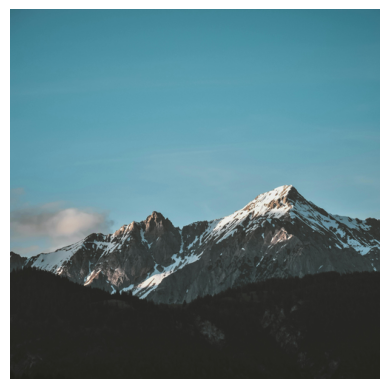

In [44]:
import matplotlib.pyplot as plt

img = base_dataset[2]
plt.imshow(img)
plt.axis('off')
plt.show()


class SuperResolutionDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, scale_pairs=[(256, 512)], transform=ToTensor()):
        self.base_dataset = base_dataset
        self.transform = transform
        self.scale_pairs = scale_pairs
        self.index_scale_map = [scale_pairs[i % len(scale_pairs)] for i in range(len(base_dataset))]

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        try:
            img = self.base_dataset[idx]
            img = img.convert("RGB")

            low_res_size, target_size = self.index_scale_map[idx]
            if target_size < 224:
                raise ValueError()

            lr_img = img.resize((low_res_size, low_res_size), Image.BICUBIC)
            hr_img = img.resize((target_size, target_size), Image.BICUBIC)

            if self.transform:
                lr_img = self.transform(lr_img)
                hr_img = self.transform(hr_img)

            return lr_img, hr_img
        except Exception as e:
            logging.error(f"error processing index {idx}: {e}")
            low_res_size, target_size = self.index_scale_map[idx]
            dummy_lr = torch.zeros(3, low_res_size, low_res_size)
            dummy_hr = torch.zeros(3, target_size, target_size)
            return dummy_lr, dummy_hr

In [45]:
sr_dataset = SuperResolutionDataset(
    base_dataset,
    scale_pairs=[(256, 512)],
)

In [46]:
train_size = int(0.8 * len(sr_dataset))
val_size = len(sr_dataset) - train_size
train_dataset, val_dataset = random_split(sr_dataset, [train_size, val_size])

batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # >0 crashing in localhost
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=False
)

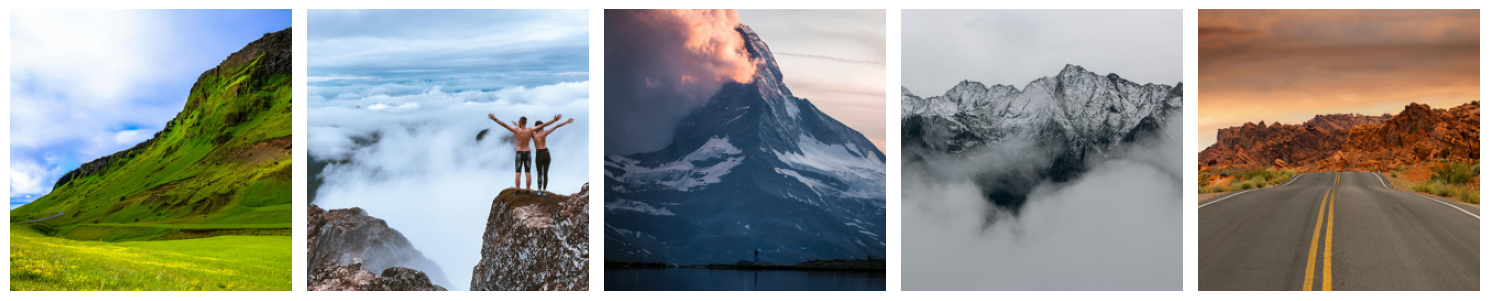

In [47]:
dataiter = iter(train_loader)
images, _ = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, upscale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


class EnhancedSuperResolutionModel(nn.Module):
    def __init__(self, num_res_blocks=16, base_channels=64, upscale_factor=2):
        super(EnhancedSuperResolutionModel, self).__init__()
        self.conv_input = nn.Conv2d(3, base_channels, kernel_size=9, padding=4)
        self.prelu = nn.PReLU()

        res_blocks = []
        for _ in range(num_res_blocks):
            res_blocks.append(ResidualBlock(base_channels))
        self.residual_layers = nn.Sequential(*res_blocks)

        self.conv_mid = nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1)
        self.bn_mid = nn.BatchNorm2d(base_channels)

        upsample_blocks = []
        num_upsample = int(torch.log2(torch.tensor(upscale_factor)).item())
        for _ in range(num_upsample):
            upsample_blocks.append(UpsampleBlock(base_channels, upscale_factor=2))
        self.upsample_layers = nn.Sequential(*upsample_blocks)

        self.conv_output = nn.Conv2d(base_channels, 3, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.conv_input(x)
        x = self.prelu(x)

        residual = self.residual_layers(x)
        residual = self.conv_mid(residual)
        residual = self.bn_mid(residual)
        x = x + residual

        x = self.upsample_layers(x)
        x = self.conv_output(x)
        return x


class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(vgg.features)[:35]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, sr, hr):
        sr_features = self.feature_extractor(sr)
        hr_features = self.feature_extractor(hr)
        loss = nn.functional.l1_loss(sr_features, hr_features)
        return loss


In [49]:
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr


def train_epoch(model, dataloader, criterion_content, criterion_perceptual, optimizer, device):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (lr, hr) in enumerate(dataloader):
        print(f"batch {batch_idx + 1}/{len(dataloader)}")
        try:
            lr = lr.to(device)
            hr = hr.to(device)

            optimizer.zero_grad()
            sr = model(lr)

            loss_content = criterion_content(sr, hr)
            loss_perceptual = criterion_perceptual(sr, hr)
            loss = loss_content + 0.1 * loss_perceptual

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        except Exception as e:
            logging.error(f"error in training batch {batch_idx + 1}: {e}")
            continue

    avg_loss = epoch_loss / len(dataloader)
    return avg_loss


def validate_epoch(model, dataloader, criterion_content, criterion_perceptual, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    num_samples_evaluated = 0

    with torch.no_grad():
        for batch_idx, (lr_imgs, hr_imgs) in enumerate(dataloader):
            try:
                lr_imgs = lr_imgs.to(device)
                hr_imgs = hr_imgs.to(device)

                sr_imgs = model(lr_imgs)

                loss_content = criterion_content(sr_imgs, hr_imgs)
                loss_perceptual = criterion_perceptual(sr_imgs, hr_imgs)
                loss = loss_content + 0.1 * loss_perceptual

                running_loss += loss.item()

                sr_np = sr_imgs.cpu().numpy().transpose(0, 2, 3, 1)
                hr_np = hr_imgs.cpu().numpy().transpose(0, 2, 3, 1)

                for j in range(sr_np.shape[0]):
                    sr_image = sr_np[j].astype(np.uint8)
                    hr_image = hr_np[j].astype(np.uint8)

                    # psnr
                    try:
                        epsilon = 1e-10
                        mse = np.mean((hr_image - sr_image) ** 2)
                        mse = max(mse, epsilon)
                        current_psnr = 10 * np.log10((255 ** 2) / mse)

                        if np.isinf(current_psnr) or np.isnan(current_psnr):
                            current_psnr = 100.0
                    except Exception as e:
                        logging.error(f"PSNR calculation error for sample {j} in batch {batch_idx + 1}: {e}")
                        current_psnr = 0.0

                    # ssim
                    try:
                        current_ssim = ssim(
                            hr_image,
                            sr_image,
                            channel_axis=-1,
                            data_range=255,
                            win_size=3
                        )
                    except ValueError as ve:
                        logging.error(f"SSIM calculation error for sample {j} in batch {batch_idx + 1}: {ve}")
                        current_ssim = 0.0

                    running_psnr += current_psnr
                    running_ssim += current_ssim
                    num_samples_evaluated += 1

            except Exception as e:
                logging.error(f"error in validation batch {batch_idx + 1}: {e}")
                continue

    if num_samples_evaluated == 0:
        avg_loss = float('nan')
        avg_psnr = float('nan')
        avg_ssim = float('nan')
    else:
        avg_loss = running_loss / len(dataloader)
        avg_psnr = running_psnr / num_samples_evaluated
        avg_ssim = running_ssim / num_samples_evaluated

    return avg_loss, avg_psnr, avg_ssim


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using: {device}")

model = EnhancedSuperResolutionModel(num_res_blocks=16, base_channels=64, upscale_factor=2).to(device)
criterion_content = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

num_epochs = 10
best_valid_loss = float('inf')
checkpoint_path = 'best_super_resolution.pth'

Using device: cuda



Epoch [1/10]
Batch 1/5
Batch 2/5
Batch 3/5
Batch 4/5
Batch 5/5
Training Loss: 0.429189
Validation Loss: 0.318392, PSNR: 112.37, SSIM: 1.0000
Epoch [1/10], Train Loss: 0.429189, Val Loss: 0.318392, Val PSNR: 112.37, Val SSIM: 1.0000
✅ Saved Best Model with Validation Loss: 0.318392

Epoch [2/10]
Batch 1/5
Batch 2/5
Batch 3/5
Batch 4/5
Batch 5/5
Training Loss: 0.264993
Validation Loss: 0.293417, PSNR: 112.37, SSIM: 1.0000
Epoch [2/10], Train Loss: 0.264993, Val Loss: 0.293417, Val PSNR: 112.37, Val SSIM: 1.0000
✅ Saved Best Model with Validation Loss: 0.293417

Epoch [3/10]
Batch 1/5
Batch 2/5
Batch 3/5
Batch 4/5
Batch 5/5
Training Loss: 0.204429
Validation Loss: 0.283483, PSNR: 112.37, SSIM: 1.0000
Epoch [3/10], Train Loss: 0.204429, Val Loss: 0.283483, Val PSNR: 112.37, Val SSIM: 1.0000
✅ Saved Best Model with Validation Loss: 0.283483

Epoch [4/10]
Batch 1/5
Batch 2/5
Batch 3/5
Batch 4/5
Batch 5/5
Training Loss: 0.201092
Validation Loss: 0.255987, PSNR: 112.37, SSIM: 1.0000
Epoch [4/

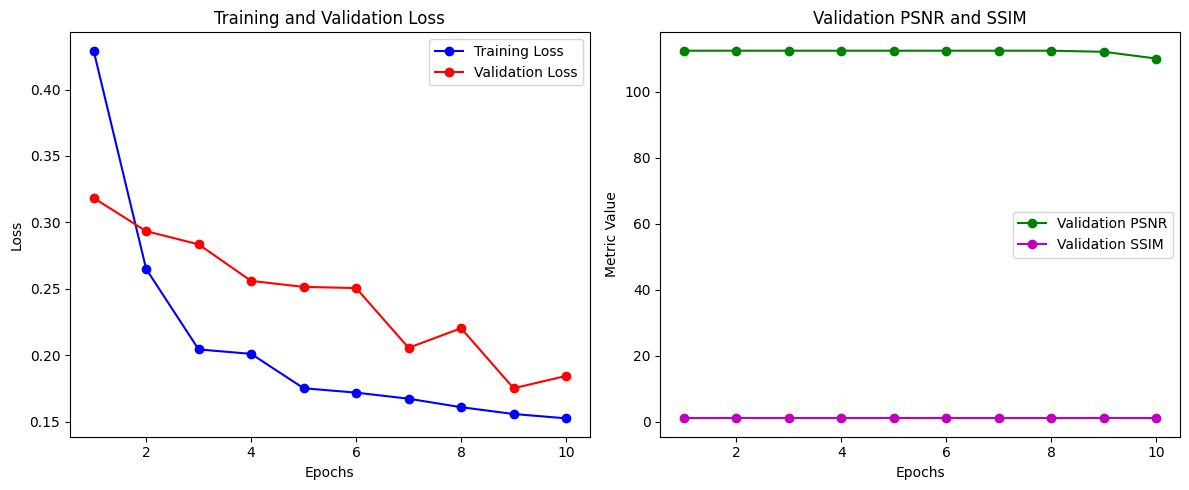

In [51]:
train_losses = []
valid_losses = []
valid_psnr = []
valid_ssim = []

for epoch in range(num_epochs):
    print(f"\nepoch [{epoch + 1}/{num_epochs}]")
    train_loss = train_epoch(model, train_loader, criterion_content, criterion_perceptual, optimizer, device)
    train_losses.append(train_loss)
    print(f"training Loss: {train_loss:.6f}")

    valid_loss, epoch_psnr, epoch_ssim = validate_epoch(model, val_loader, criterion_content, criterion_perceptual,
                                                        device)
    valid_losses.append(valid_loss)
    valid_psnr.append(epoch_psnr)
    valid_ssim.append(epoch_ssim)
    print(f"validation Loss: {valid_loss:.6f}, PSNR: {epoch_psnr:.2f}, SSIM: {epoch_ssim:.4f}")

    print(f"epoch [{epoch + 1}/{num_epochs}],"
          f" train Loss: {train_loss:.6f},"
          f" val Loss: {valid_loss:.6f},"
          f" val PSNR: {epoch_psnr:.2f},"
          f" val SSIM: {epoch_ssim:.4f}")

    scheduler.step()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ saved Best Model with Validation Loss: {best_valid_loss:.6f} 🎊")
    else:
        print("no improvement in validation loss")

# plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, valid_psnr, 'go-', label='Validation PSNR')
plt.plot(epochs, valid_ssim, 'mo-', label='Validation SSIM')
plt.title('Validation PSNR and SSIM')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()

plt.tight_layout()
plt.show()

### Loading best model

In [52]:
state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
best_model = EnhancedSuperResolutionModel(num_res_blocks=16, base_channels=64, upscale_factor=2).to(device)
best_model.load_state_dict(state_dict)
best_model.eval()

EnhancedSuperResolutionModel(
  (conv_input): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (prelu): PReLU(num_parameters=1)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [60]:
import skimage

print(skimage.__version__)

0.25.0


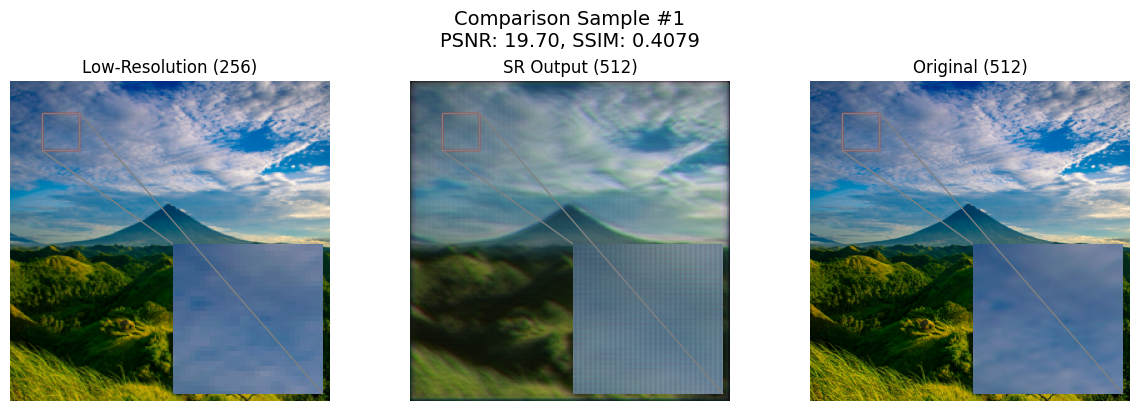

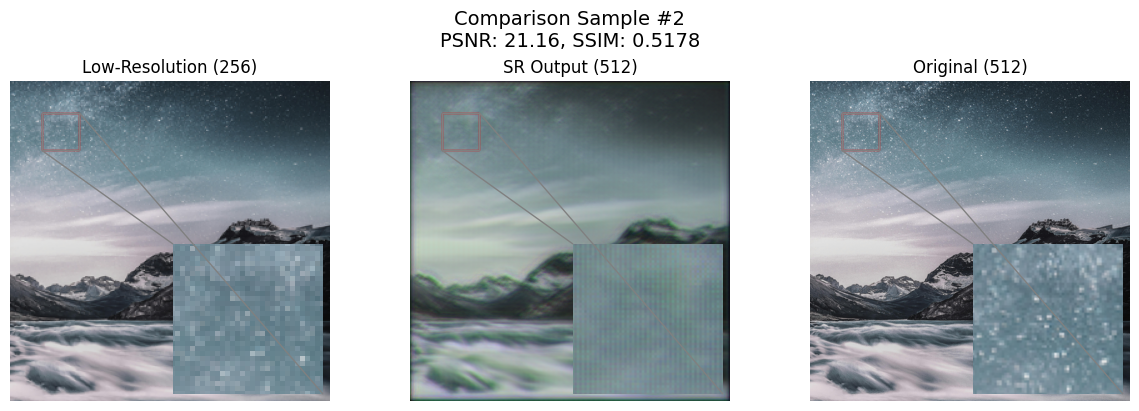

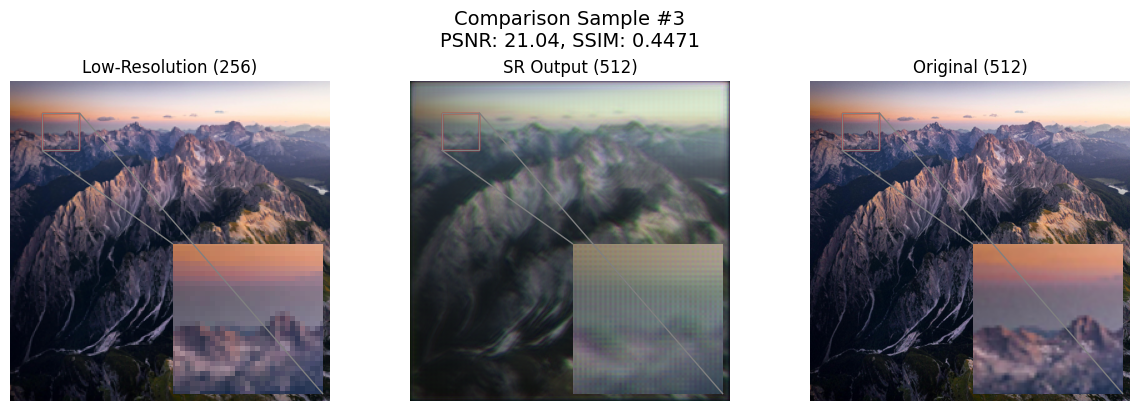

In [62]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def final_evaluation_and_comparison(model, dataloader, device, sample_count=3):
    model.eval()
    data_iter = iter(dataloader)
    images_shown = 0

    ref_zoom_x0, ref_zoom_y0, ref_zoom_w, ref_zoom_h = 50, 50, 60, 60

    with torch.no_grad():
        for lr_batch, hr_batch in data_iter:
            # Move data to device
            lr_batch = lr_batch.to(device)
            sr_batch = model(lr_batch)

            # Convert to numpy [H, W, C]
            lr_batch = lr_batch.cpu().numpy().transpose(0, 2, 3, 1)
            sr_batch = sr_batch.cpu().numpy().transpose(0, 2, 3, 1)
            hr_batch = hr_batch.numpy().transpose(0, 2, 3, 1)

            batch_size = lr_batch.shape[0]
            for i in range(batch_size):
                if images_shown >= sample_count:
                    return

                lr_img = (lr_batch[i] * 255.0).clip(0, 255).astype(np.uint8)
                sr_img = (sr_batch[i] * 255.0).clip(0, 255).astype(np.uint8)
                hr_img = (hr_batch[i] * 255.0).clip(0, 255).astype(np.uint8)

                # psnr, ssim metrics, (niqe unfortunately does not work for now)
                try:
                    sr_psnr = psnr(hr_img, sr_img, data_range=255)
                except Exception:
                    sr_psnr = 0.0  # fallback
                try:
                    # ssim expects shape [H, W, C], which we have, so just specify channel_axis:
                    sr_ssim = ssim(hr_img, sr_img, channel_axis=-1, data_range=255, win_size=7)
                except Exception:
                    sr_ssim = 0.0  # fallback
                # try:
                #     sr_img_float = sr_img.astype('float64') / 255.0
                #     sr_niqe = niqe(sr_img_float)
                # except Exception:
                #     print("NIQE error:", sys.exc_info()[0])
                #     sr_niqe = 0.0  # fallback

                fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
                fig.suptitle(
                    f"Comparison Sample #{images_shown + 1}\nPSNR: {sr_psnr:.2f}, SSIM: {sr_ssim:.4f}",
                    fontsize=14
                )

                titles = ["Low-Resolution (256)", "SR Output (512)", "Original (512)"]
                images = [lr_img, sr_img, hr_img]

                for ax, title, im in zip(axes, titles, images):
                    ax.imshow(im)
                    ax.set_title(title)
                    ax.axis('off')

                    h, w, _ = im.shape
                    scale = w / 512.0

                    # scaled rectangle for the current image
                    rect_x0 = ref_zoom_x0 * scale
                    rect_y0 = ref_zoom_y0 * scale
                    rect_w = ref_zoom_w * scale
                    rect_h = ref_zoom_h * scale

                    rect = patches.Rectangle(
                        (rect_x0, rect_y0), rect_w, rect_h,
                        linewidth=1, edgecolor='r', facecolor='none'
                    )
                    ax.add_patch(rect)

                    # add inset zoom
                    axins = zoomed_inset_axes(ax, 4, loc='lower right')
                    axins.imshow(im)
                    axins.set_xlim(rect_x0, rect_x0 + rect_w)
                    axins.set_ylim(rect_y0 + rect_h, rect_y0)
                    axins.axis('off')
                    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

                plt.show()
                images_shown += 1


final_evaluation_and_comparison(best_model, val_loader, device, sample_count=3)

In [ ]:
import time

def measure_inference_time(model, dataloader, device):
    model.eval()
    start = time.time()

    with torch.no_grad():
        for lr_batch, _ in dataloader:
            lr_batch = lr_batch.to(device)
            # Single forward pass
            _ = model(lr_batch)

    end = time.time()
    elapsed = end - start

    num_images = len(dataloader.dataset)
    avg_time_per_image = elapsed / num_images
    print(f"average inference time per image: {avg_time_per_image*1000:.2f} ms")


measure_inference_time(best_model, val_loader, device)